In [1]:
#creates database to contain all outputs we could need for future plotting. 
#concs, temps, RFs, emmissions, CO2_fe emms for both MAGICC and FAIR params


#MAKE IT BOTH ADDING AND DIFFERENCING!!!!!
#REMOVE PLOTTING SECTION EVENTUALLY
#ADD OTHER DATAFILES EG RCP85

In [2]:
#Imports and Setup

import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage.filters import gaussian_filter as smooth


#REMOVE EVENTUALLY
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 3

font = {'weight' : 'normal',
      'size'   : 17}

plt.rc('font', **font)
#--------------


import fair
from fair.fair_inverse_model import co2_conc_total as rf_to_conc
from fair.fair_inverse_model import annual_emissions_calc2 as conc_to_emissions
from fair.forward_multiple_GHG import fair_scm as FAIR_model
fair.__version__

'1.0.1'

In [3]:
#IMPORT DATA FROM RCP3PD DATAFILES

emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0 * 0.73

concs_filem = './fair/GCP_data/RCP3PD_MIDYEAR_CONCENTRATIONS.csv'
concs_datam = np.genfromtxt(concs_filem,skip_header=37,delimiter=',',names=True)
M_concs = concs_datam['CH4']
N_concs = concs_datam['N2O']
concs = concs_datam['CO2']

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']


In [4]:
### ---- ADDING using FAIR STANDARD parameters ----

# Calculate the concs, temps, RFs and emissions

#total
out_total_add_fair = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#just CO2
out_co2_add_fair = FAIR_model(emissions=emissions,MAGICC_model = True)

#just CH4
out_ch4_add_fair = FAIR_model(other_rf = np.zeros(emissions.size),M_emissions=M_emissions,
                     N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                     S_T_CH4 = 0.035, tau_M_0 = 9.0)

#just N2O
out_n2o_add_fair = FAIR_model(other_rf = np.zeros(emissions.size),N_emissions=N_emissions,
                     N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                     S_T_CH4 = 0.035, tau_M_0 = 9.0)

#just other
out_other_add_fair = FAIR_model(other_rf = other_rf,N_0=270.0,MAGICC_model = True,
                       S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)
    
#anthro total from RCP3 RF datafile    
out_anthro_0_add_fair = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                          N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                          S_T_CH4 = 0.035, tau_M_0 = 9.0)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

#smoothing
ANTHRO_RF_0_add_fair = smooth(out_anthro_0_add_fair['forcing']['total'],5)
ANTHRO_RF_add_fair = smooth(out_total_add_fair['forcing']['total'],5)
CH4_RF_add_fair = smooth(out_ch4_add_fair['forcing']['total'],5)
N2O_RF_add_fair = smooth(out_n2o_add_fair['forcing']['total'],5)
CO2_RF_add_fair = smooth(out_co2_add_fair['forcing']['total'],5)
other_RF_add_fair = smooth(out_other_add_fair['forcing']['total'],5)
#concentrations
ANTHRO_conc_add_fair = rf_to_conc(ANTHRO_RF_add_fair)
CH4_conc_add_fair = rf_to_conc(CH4_RF_add_fair)
CO2_conc_add_fair = rf_to_conc(CO2_RF_add_fair)
N2O_conc_add_fair = rf_to_conc(N2O_RF_add_fair)
other_conc_add_fair = rf_to_conc(other_RF_add_fair)
ANTHRO_conc_0_add_fair = rf_to_conc(ANTHRO_RF_0_add_fair)
#co2-fe emissions
anthro_CO2_fe_emms_add_fair = conc_to_emissions(ANTHRO_conc_add_fair,out_total_add_fair['temperature'],year_smoothing=0)* 44./12.
CH4_CO2_fe_emms_add_fair = conc_to_emissions(CH4_conc_add_fair,out_ch4_add_fair['temperature'],year_smoothing=0)* 44./12.
CO2_CO2_fe_emms_add_fair = conc_to_emissions(CO2_conc_add_fair,out_co2_add_fair['temperature'],year_smoothing=0)* 44./12.
N2O_CO2_fe_emms_add_fair = conc_to_emissions(N2O_conc_add_fair,out_n2o_add_fair['temperature'],year_smoothing=0)* 44./12.
other_CO2_fe_emms_add_fair = conc_to_emissions(other_conc_add_fair,out_other_add_fair['temperature'],year_smoothing=0)* 44./12.
anthro_CO2_fe_emms_0_add_fair = conc_to_emissions(ANTHRO_conc_0_add_fair,out_anthro_0_add_fair['temperature'],year_smoothing=0)* 44./12.


# Creating the dictionaries to then be nested within one output
emissions_add_fair = {'CO2' : CO2_CO2_fe_emms_add_fair, 'CH4' : CH4_CO2_fe_emms_add_fair, 'N2O' : N2O_CO2_fe_emms_add_fair, 
                          'other' : other_CO2_fe_emms_add_fair, 'total' : anthro_CO2_fe_emms_add_fair, 'anthro_0' : anthro_CO2_fe_emms_0_add_fair}

concentration_add_fair = {'CO2' : CO2_conc_add_fair, 'CH4' : CH4_conc_add_fair, 'N2O' : N2O_conc_add_fair, 
                              'other' : other_conc_add_fair, 'total' : ANTHRO_conc_add_fair, 'anthro_0' : ANTHRO_conc_0_add_fair}
    
forcing_add_fair = {'total' : ANTHRO_RF_add_fair, 'other' : other_RF_add_fair, 'CO2' : CO2_RF_add_fair, 
                        'CH4' : CH4_RF_add_fair, 'N2O' : N2O_RF_add_fair, 'anthro_0' : ANTHRO_RF_0_add_fair}
    
temperature_add_fair = {'total' : out_total_add_fair['temperature'], 'other' : out_other_add_fair['temperature'], 'CO2' : out_co2_add_fair['temperature'], 
                            'CH4' : out_ch4_add_fair['temperature'], 'N2O' : out_n2o_add_fair['temperature'], 'anthro_0' : out_anthro_0_add_fair['temperature']}
    
# Nest again in the adding fair part
adding_fair = {'emissions' : emissions_add_fair , 'concentration' : concentration_add_fair , 'forcing' : forcing_add_fair , 'temperature' : temperature_add_fair} 


In [18]:
### ---- DIFFERENCING using FAIR STANDARD parameters ----

# Calculate the concs, temps, RFs and emissions

#total
out_total_diff_fair = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus CO2
out_co2_diff_fair = FAIR_model(M_emissions=M_emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus CH4
out_ch4_diff_fair = FAIR_model(emissions=emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus N2O
out_n2o_diff_fair = FAIR_model(emissions=emissions,M_emissions=M_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus other
out_other_diff_fair = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                            S_T_CH4 = 0.035, tau_M_0 = 9.0)
    
#anthro total from RCP3 RF datafile    
out_anthro_0_diff_fair = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                          N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                          S_T_CH4 = 0.035, tau_M_0 = 9.0)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

#smoothing
ANTHRO_RF_0_diff_fair = smooth(out_anthro_0_diff_fair['forcing']['total'],5)
ANTHRO_RF_diff_fair = smooth(out_total_diff_fair['forcing']['total'],5)
anthro_minus_CH4_RF_diff_fair = smooth(out_ch4_diff_fair['forcing']['total'],5)
anthro_minus_N2O_RF_diff_fair = smooth(out_n2o_diff_fair['forcing']['total'],5)
anthro_minus_CO2_RF_diff_fair = smooth(out_co2_diff_fair['forcing']['total'],5)
anthro_minus_other_RF_diff_fair = smooth(out_other_diff_fair['forcing']['total'],5)

CH4_RF_diff_fair = ANTHRO_RF_diff_fair - anthro_minus_CH4_RF_diff_fair
N2O_RF_diff_fair = ANTHRO_RF_diff_fair - anthro_minus_N2O_RF_diff_fair
CO2_RF_diff_fair = ANTHRO_RF_diff_fair - anthro_minus_CO2_RF_diff_fair
other_RF_diff_fair = ANTHRO_RF_diff_fair - anthro_minus_other_RF_diff_fair

#concentrations
ANTHRO_conc_diff_fair = rf_to_conc(ANTHRO_RF_diff_fair)
anthro_minus_CH4_conc_diff_fair = rf_to_conc(anthro_minus_CH4_RF_diff_fair)
anthro_minus_CO2_conc_diff_fair = rf_to_conc(anthro_minus_CO2_RF_diff_fair)
anthro_minus_N2O_conc_diff_fair = rf_to_conc(anthro_minus_N2O_RF_diff_fair)
anthro_minus_other_conc_diff_fair = rf_to_conc(anthro_minus_other_RF_diff_fair)
ANTHRO_conc_0_diff_fair = rf_to_conc(ANTHRO_RF_0_diff_fair)

CH4_conc_diff_fair = ANTHRO_conc_diff_fair - anthro_minus_CH4_conc_diff_fair + C_0
N2O_conc_diff_fair = ANTHRO_conc_diff_fair - anthro_minus_N2O_conc_diff_fair + C_0
CO2_conc_diff_fair = ANTHRO_conc_diff_fair - anthro_minus_CO2_conc_diff_fair + C_0
other_conc_diff_fair = ANTHRO_conc_diff_fair - anthro_minus_other_conc_diff_fair + C_0

#co2-fe emissions
anthro_CO2_fe_emms_diff_fair = conc_to_emissions(ANTHRO_conc_diff_fair,out_total_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_minus_CH4_diff_fair = conc_to_emissions(anthro_minus_CH4_conc_diff_fair,out_ch4_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_minus_CO2_diff_fair = conc_to_emissions(anthro_minus_CO2_conc_diff_fair,out_co2_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_minus_N2O_diff_fair = conc_to_emissions(anthro_minus_N2O_conc_diff_fair,out_n2o_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_minus_other_diff_fair = conc_to_emissions(anthro_minus_other_conc_diff_fair,out_other_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_CO2_fe_emms_0_diff_fair = conc_to_emissions(ANTHRO_conc_0_diff_fair,out_anthro_0_diff_fair['temperature'],year_smoothing=0)* 44./12.

CH4_CO2_fe_emms_diff_fair = anthro_CO2_fe_emms_diff_fair - anthro_minus_CH4_diff_fair
N2O_CO2_fe_emms_diff_fair = anthro_CO2_fe_emms_diff_fair - anthro_minus_N2O_diff_fair
CO2_CO2_fe_emms_diff_fair = anthro_CO2_fe_emms_diff_fair - anthro_minus_CO2_diff_fair
other_CO2_fe_emms_diff_fair = anthro_CO2_fe_emms_diff_fair - anthro_minus_other_diff_fair

#temperatures
T_total = out_total_diff_fair['temperature']
T_other = T_total - out_other_diff_fair['temperature']
T_co2 = T_total - out_co2_diff_fair['temperature']
T_ch4 = T_total - out_ch4_diff_fair['temperature']
T_n2o = T_total - out_n2o_diff_fair['temperature']
T_anthro_0 = out_anthro_0_diff_fair['temperature']


# Creating the dictionaries to then be nested within one output
emissions_diff_fair = {'CO2' : CO2_CO2_fe_emms_diff_fair, 'CH4' : CH4_CO2_fe_emms_diff_fair, 'N2O' : N2O_CO2_fe_emms_diff_fair, 
                          'other' : other_CO2_fe_emms_diff_fair, 'total' : anthro_CO2_fe_emms_diff_fair, 'anthro_0' : anthro_CO2_fe_emms_0_diff_fair}

concentration_diff_fair = {'CO2' : CO2_conc_diff_fair, 'CH4' : CH4_conc_diff_fair, 'N2O' : N2O_conc_diff_fair, 
                              'other' : other_conc_diff_fair, 'total' : ANTHRO_conc_diff_fair, 'anthro_0' : ANTHRO_conc_0_diff_fair}
    
forcing_diff_fair = {'total' : ANTHRO_RF_diff_fair, 'other' : other_RF_diff_fair, 'CO2' : CO2_RF_diff_fair, 
                        'CH4' : CH4_RF_diff_fair, 'N2O' : N2O_RF_diff_fair, 'anthro_0' : ANTHRO_RF_0_diff_fair}
    
temperature_diff_fair = {'total' : T_total, 'other' : T_other, 'CO2' : T_co2, 
                            'CH4' : T_ch4, 'N2O' : T_n2o, 'anthro_0' : T_anthro_0}
    
# Nest again in the adding fair part
diff_fair = {'emissions' : emissions_diff_fair , 'concentration' : concentration_diff_fair , 'forcing' : forcing_diff_fair , 'temperature' : temperature_diff_fair} 


In [19]:
### ---- ADDING using MAGICC parameters ----

# Calculate the concs, temps, RFs and emissions

#PARAMETERS
C_0 = 279.51
F_2x= 3.71
a = np.array([0.05,0.236489403703,0.3,0.413510596297])
r0 = 39.1193644809
rC=0.0152
rT=3.332


#total
out_total_add_magicc = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just CO2
out_co2_add_magicc = FAIR_model(emissions=emissions,N_0=270.0,MAGICC_model = True,
                              S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                              F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just CH4
out_ch4_add_magicc = FAIR_model(other_rf = np.zeros(emissions.size),M_emissions=M_emissions,
                     N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                     S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just N2O
out_n2o_add_magicc= FAIR_model(other_rf = np.zeros(emissions.size),N_emissions=N_emissions,
                     N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                     S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just other
out_other_add_magicc = FAIR_model(other_rf = other_rf,N_0=270.0,MAGICC_model = True,
                       S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
    
#anthro total from RCP3 RF datafile    
out_anthro_0_add_magicc = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                          N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                          S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

#smoothing
ANTHRO_RF_0_add_magicc = smooth(out_anthro_0_add_magicc['forcing']['total'],5)
ANTHRO_RF_add_magicc = smooth(out_total_add_magicc['forcing']['total'],5)
CH4_RF_add_magicc = smooth(out_ch4_add_magicc['forcing']['total'],5)
N2O_RF_add_magicc = smooth(out_n2o_add_magicc['forcing']['total'],5)
CO2_RF_add_magicc = smooth(out_co2_add_magicc['forcing']['total'],5)
other_RF_add_magicc = smooth(out_other_add_magicc['forcing']['total'],5)
#concentrations
ANTHRO_conc_add_magicc = rf_to_conc(ANTHRO_RF_add_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
CH4_conc_add_magicc = rf_to_conc(CH4_RF_add_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
CO2_conc_add_magicc = rf_to_conc(CO2_RF_add_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
N2O_conc_add_magicc = rf_to_conc(N2O_RF_add_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
other_conc_add_magicc = rf_to_conc(other_RF_add_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
ANTHRO_conc_0_add_magicc = rf_to_conc(ANTHRO_RF_0_add_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
#co2-fe emissions
anthro_CO2_fe_emms_add_magicc = conc_to_emissions(ANTHRO_conc_add_magicc,out_total_add_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
CH4_CO2_fe_emms_add_magicc = conc_to_emissions(CH4_conc_add_magicc,out_ch4_add_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
CO2_CO2_fe_emms_add_magicc = conc_to_emissions(CO2_conc_add_magicc,out_co2_add_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
N2O_CO2_fe_emms_add_magicc = conc_to_emissions(N2O_conc_add_magicc,out_n2o_add_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
other_CO2_fe_emms_add_magicc = conc_to_emissions(other_conc_add_magicc,out_other_add_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
anthro_CO2_fe_emms_0_add_magicc = conc_to_emissions(ANTHRO_conc_0_add_magicc,out_anthro_0_add_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.


# Creating the dictionaries to then be nested within one output
emissions_add_magicc = {'CO2' : CO2_CO2_fe_emms_add_magicc, 'CH4' : CH4_CO2_fe_emms_add_magicc, 'N2O' : N2O_CO2_fe_emms_add_magicc, 
                          'other' : other_CO2_fe_emms_add_magicc, 'total' : anthro_CO2_fe_emms_add_magicc, 'anthro_0' : anthro_CO2_fe_emms_0_add_magicc}

concentration_add_magicc = {'CO2' : CO2_conc_add_magicc, 'CH4' : CH4_conc_add_magicc, 'N2O' : N2O_conc_add_magicc, 
                              'other' : other_conc_add_magicc, 'total' : ANTHRO_conc_add_magicc, 'anthro_0' : ANTHRO_conc_0_add_magicc}
    
forcing_add_magicc = {'total' : ANTHRO_RF_add_magicc, 'other' : other_RF_add_magicc, 'CO2' : CO2_RF_add_magicc, 
                        'CH4' : CH4_RF_add_magicc, 'N2O' : N2O_RF_add_magicc, 'anthro_0' : ANTHRO_RF_0_add_magicc}
    
temperature_add_magicc = {'total' : out_total_add_magicc['temperature'], 'other' : out_other_add_magicc['temperature'], 'CO2' : out_co2_add_magicc['temperature'], 
                            'CH4' : out_ch4_add_magicc['temperature'], 'N2O' : out_n2o_add_magicc['temperature'], 'anthro_0' : out_anthro_0_add_magicc['temperature']}
    
# Nest again in the adding fair part
adding_magicc = {'emissions' : emissions_add_magicc , 'concentration' : concentration_add_magicc , 'forcing' : forcing_add_magicc , 'temperature' : temperature_add_magicc}

In [20]:
### ---- DIFFERENCING using MAGICC parameters ----

# Calculate the concs, temps, RFs and emissions

#total
out_total_diff_magicc = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#total minus CO2
out_co2_diff_magicc = FAIR_model(M_emissions=M_emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#total minus CH4
out_ch4_diff_magicc = FAIR_model(emissions=emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#total minus N2O
out_n2o_diff_magicc = FAIR_model(emissions=emissions,M_emissions=M_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#total minus other
out_other_diff_magicc = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                            S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
    
#anthro total from RCP3 RF datafile    
out_anthro_0_diff_magicc = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                          N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                          S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

#smoothing
ANTHRO_RF_0_diff_magicc = smooth(out_anthro_0_diff_magicc['forcing']['total'],5)
ANTHRO_RF_diff_magicc = smooth(out_total_diff_magicc['forcing']['total'],5)
anthro_minus_CH4_RF_diff_magicc = smooth(out_ch4_diff_magicc['forcing']['total'],5)
anthro_minus_N2O_RF_diff_magicc = smooth(out_n2o_diff_magicc['forcing']['total'],5)
anthro_minus_CO2_RF_diff_magicc = smooth(out_co2_diff_magicc['forcing']['total'],5)
anthro_minus_other_RF_diff_magicc = smooth(out_other_diff_magicc['forcing']['total'],5)

CH4_RF_diff_magicc = ANTHRO_RF_diff_magicc - anthro_minus_CH4_RF_diff_magicc
N2O_RF_diff_magicc = ANTHRO_RF_diff_magicc - anthro_minus_N2O_RF_diff_magicc
CO2_RF_diff_magicc = ANTHRO_RF_diff_magicc - anthro_minus_CO2_RF_diff_magicc
other_RF_diff_magicc = ANTHRO_RF_diff_magicc - anthro_minus_other_RF_diff_magicc

#concentrations
ANTHRO_conc_diff_magicc = rf_to_conc(ANTHRO_RF_diff_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
anthro_minus_CH4_conc_diff_magicc = rf_to_conc(anthro_minus_CH4_RF_diff_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
anthro_minus_CO2_conc_diff_magicc = rf_to_conc(anthro_minus_CO2_RF_diff_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
anthro_minus_N2O_conc_diff_magicc = rf_to_conc(anthro_minus_N2O_RF_diff_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
anthro_minus_other_conc_diff_magicc = rf_to_conc(anthro_minus_other_RF_diff_magicc, a = F_2x/np.log(2) , Cpreind = C_0)
ANTHRO_conc_0_diff_magicc = rf_to_conc(ANTHRO_RF_0_diff_magicc, a = F_2x/np.log(2) , Cpreind = C_0)

CH4_conc_diff_magicc = ANTHRO_conc_diff_magicc - anthro_minus_CH4_conc_diff_magicc + C_0
N2O_conc_diff_magicc = ANTHRO_conc_diff_magicc - anthro_minus_N2O_conc_diff_magicc + C_0
CO2_conc_diff_magicc = ANTHRO_conc_diff_magicc - anthro_minus_CO2_conc_diff_magicc + C_0
other_conc_diff_magicc = ANTHRO_conc_diff_magicc - anthro_minus_other_conc_diff_magicc + C_0

#co2-fe emissions
anthro_CO2_fe_emms_diff_magicc = conc_to_emissions(ANTHRO_conc_diff_magicc,out_total_diff_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
anthro_minus_CH4_diff_magicc = conc_to_emissions(anthro_minus_CH4_conc_diff_magicc,out_ch4_diff_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
anthro_minus_CO2_diff_magicc = conc_to_emissions(anthro_minus_CO2_conc_diff_magicc,out_co2_diff_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
anthro_minus_N2O_diff_magicc = conc_to_emissions(anthro_minus_N2O_conc_diff_magicc,out_n2o_diff_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
anthro_minus_other_diff_magicc = conc_to_emissions(anthro_minus_other_conc_diff_magicc,out_other_diff_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.
anthro_CO2_fe_emms_0_diff_magicc = conc_to_emissions(ANTHRO_conc_0_diff_magicc,out_anthro_0_diff_magicc['temperature'],year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)* 44./12.

CH4_CO2_fe_emms_diff_magicc = anthro_CO2_fe_emms_diff_magicc - anthro_minus_CH4_diff_magicc
N2O_CO2_fe_emms_diff_magicc = anthro_CO2_fe_emms_diff_magicc - anthro_minus_N2O_diff_magicc
CO2_CO2_fe_emms_diff_magicc = anthro_CO2_fe_emms_diff_magicc - anthro_minus_CO2_diff_magicc
other_CO2_fe_emms_diff_magicc = anthro_CO2_fe_emms_diff_magicc - anthro_minus_other_diff_magicc

#temperatures
T_total_magicc = out_total_diff_magicc['temperature']
T_other_magicc = T_total - out_other_diff_magicc['temperature']
T_co2_magicc = T_total - out_co2_diff_magicc['temperature']
T_ch4_magicc = T_total - out_ch4_diff_magicc['temperature']
T_n2o_magicc = T_total - out_n2o_diff_magicc['temperature']
T_anthro_0_magicc = out_anthro_0_diff_magicc['temperature']


# Creating the dictionaries to then be nested within one output
emissions_diff_magicc = {'CO2' : CO2_CO2_fe_emms_diff_magicc, 'CH4' : CH4_CO2_fe_emms_diff_magicc, 'N2O' : N2O_CO2_fe_emms_diff_magicc, 
                          'other' : other_CO2_fe_emms_diff_magicc, 'total' : anthro_CO2_fe_emms_diff_magicc, 'anthro_0' : anthro_CO2_fe_emms_0_diff_magicc}

concentration_diff_magicc = {'CO2' : CO2_conc_diff_magicc, 'CH4' : CH4_conc_diff_magicc, 'N2O' : N2O_conc_diff_magicc, 
                              'other' : other_conc_diff_magicc, 'total' : ANTHRO_conc_diff_magicc, 'anthro_0' : ANTHRO_conc_0_diff_magicc}
    
forcing_diff_magicc = {'total' : ANTHRO_RF_diff_magicc, 'other' : other_RF_diff_magicc, 'CO2' : CO2_RF_diff_magicc, 
                        'CH4' : CH4_RF_diff_magicc, 'N2O' : N2O_RF_diff_magicc, 'anthro_0' : ANTHRO_RF_0_diff_magicc}
    
temperature_diff_magicc = {'total' : T_total_magicc, 'other' : T_other_magicc, 'CO2' : T_co2_magicc, 
                            'CH4' : T_ch4_magicc, 'N2O' : T_n2o_magicc, 'anthro_0' : T_anthro_0_magicc}
    
# Nest again in the adding fair part
diff_magicc = {'emissions' : emissions_diff_magicc , 'concentration' : concentration_diff_magicc , 'forcing' : forcing_diff_magicc , 'temperature' : temperature_diff_magicc} 



In [21]:
# Create the output dictionary
output = {'adding_fair' : adding_fair , 'differencing_fair' : diff_fair , 'adding_magicc' : adding_magicc , 'differencing_magicc' : diff_magicc} 

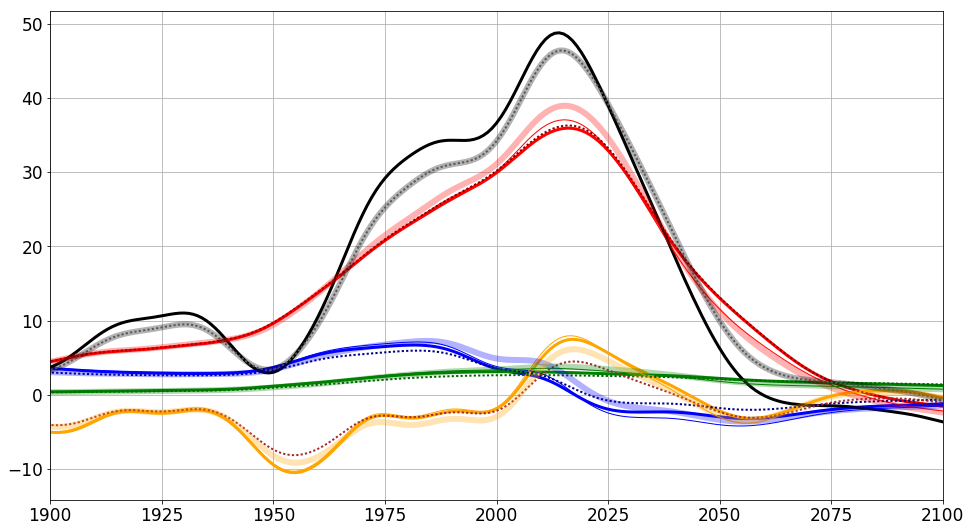

In [22]:
time = np.arange(1765,2501)
plt.plot(time, output['adding_fair']['emissions']['CO2'], color = 'red')
plt.plot(time, output['adding_fair']['emissions']['CH4'], color = 'blue')
plt.plot(time, output['adding_fair']['emissions']['N2O'], color = 'green')
plt.plot(time, output['adding_fair']['emissions']['other'], color = 'orange')
plt.plot(time, output['adding_fair']['emissions']['anthro_0'], color = 'black')
plt.plot(time, output['differencing_fair']['emissions']['CO2'], color = 'red', linewidth = 1)
plt.plot(time, output['differencing_fair']['emissions']['CH4'], color = 'blue', linewidth = 1)
plt.plot(time, output['differencing_fair']['emissions']['N2O'], color = 'green', linewidth = 1)
plt.plot(time, output['differencing_fair']['emissions']['other'], color = 'orange', linewidth = 1)
plt.plot(time, output['differencing_fair']['emissions']['anthro_0'], color = 'black', linewidth = 1)
plt.plot(time, output['adding_magicc']['emissions']['CO2'], ':', color = 'darkred', linewidth = 2)
plt.plot(time, output['adding_magicc']['emissions']['CH4'], ':', color = 'darkblue', linewidth = 2)
plt.plot(time, output['adding_magicc']['emissions']['N2O'], ':', color = 'darkgreen', linewidth = 2)
plt.plot(time, output['adding_magicc']['emissions']['other'], ':', color = 'brown', linewidth = 2)
plt.plot(time, output['adding_magicc']['emissions']['anthro_0'], ':', color = 'grey', linewidth = 2)
plt.plot(time, output['differencing_magicc']['emissions']['CO2'], color = 'red', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['emissions']['CH4'], color = 'blue', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['emissions']['N2O'], color = 'green', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['emissions']['other'], color = 'orange', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['emissions']['anthro_0'], color = 'black', linewidth = 6, alpha = 0.3)
plt.xlim(1900,2100)
plt.grid(True)

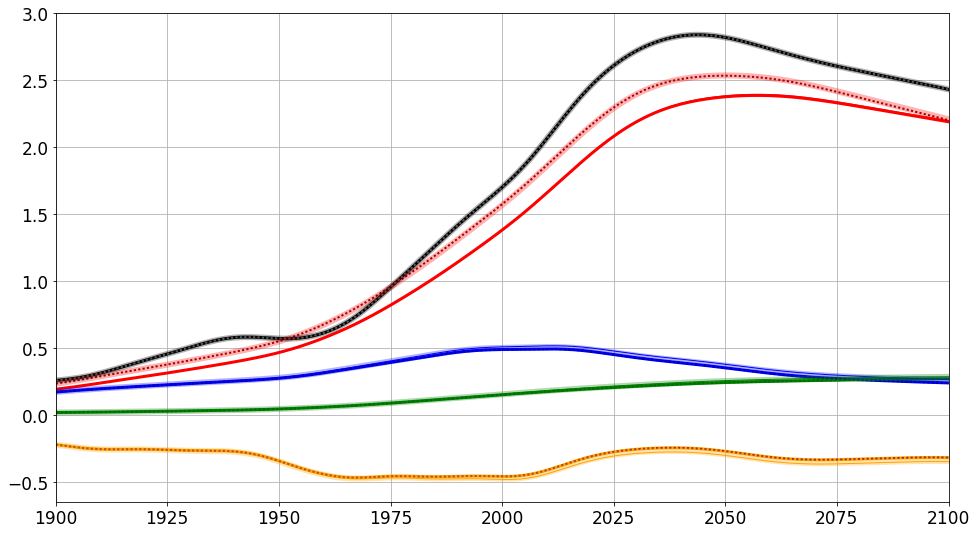

In [23]:
plt.figure()

plt.plot(time, output['adding_fair']['forcing']['CO2'], color = 'red')
plt.plot(time, output['adding_fair']['forcing']['CH4'], color = 'blue')
plt.plot(time, output['adding_fair']['forcing']['N2O'], color = 'green')
plt.plot(time, output['adding_fair']['forcing']['other'], color = 'orange')
plt.plot(time, output['adding_fair']['forcing']['anthro_0'], color = 'black')
plt.plot(time, output['differencing_fair']['forcing']['CO2'], color = 'red', linewidth = 1)
plt.plot(time, output['differencing_fair']['forcing']['CH4'], color = 'blue', linewidth = 1)
plt.plot(time, output['differencing_fair']['forcing']['N2O'], color = 'green', linewidth = 1)
plt.plot(time, output['differencing_fair']['forcing']['other'], color = 'orange', linewidth = 1)
plt.plot(time, output['differencing_fair']['forcing']['anthro_0'], color = 'black', linewidth = 1)
plt.plot(time, output['adding_magicc']['forcing']['CO2'], ':', color = 'darkred', linewidth = 2)
plt.plot(time, output['adding_magicc']['forcing']['CH4'], ':', color = 'darkblue', linewidth = 2)
plt.plot(time, output['adding_magicc']['forcing']['N2O'], ':', color = 'darkgreen', linewidth = 2)
plt.plot(time, output['adding_magicc']['forcing']['other'], ':', color = 'brown', linewidth = 2)
plt.plot(time, output['adding_magicc']['forcing']['anthro_0'], ':', color = 'grey', linewidth = 2)
plt.plot(time, output['differencing_magicc']['forcing']['CO2'], color = 'red', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['forcing']['CH4'], color = 'blue', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['forcing']['N2O'], color = 'green', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['forcing']['other'], color = 'orange', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['forcing']['anthro_0'], color = 'black', linewidth = 6, alpha = 0.3)
plt.xlim(1900,2100)
plt.grid(True)

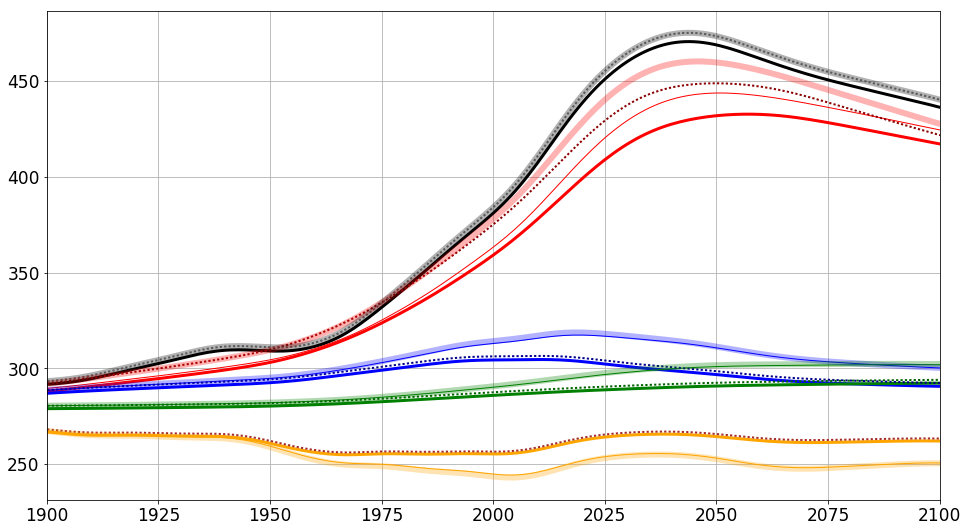

In [24]:
plt.figure()

plt.plot(time, output['adding_fair']['concentration']['CO2'], color = 'red')
plt.plot(time, output['adding_fair']['concentration']['CH4'], color = 'blue')
plt.plot(time, output['adding_fair']['concentration']['N2O'], color = 'green')
plt.plot(time, output['adding_fair']['concentration']['other'], color = 'orange')
plt.plot(time, output['adding_fair']['concentration']['anthro_0'], color = 'black')
plt.plot(time, output['differencing_fair']['concentration']['CO2'], color = 'red', linewidth = 1)
plt.plot(time, output['differencing_fair']['concentration']['CH4'], color = 'blue', linewidth = 1)
plt.plot(time, output['differencing_fair']['concentration']['N2O'], color = 'green', linewidth = 1)
plt.plot(time, output['differencing_fair']['concentration']['other'], color = 'orange', linewidth = 1)
plt.plot(time, output['differencing_fair']['concentration']['anthro_0'], color = 'black', linewidth = 1)
plt.plot(time, output['adding_magicc']['concentration']['CO2'], ':', color = 'darkred', linewidth = 2)
plt.plot(time, output['adding_magicc']['concentration']['CH4'], ':', color = 'darkblue', linewidth = 2)
plt.plot(time, output['adding_magicc']['concentration']['N2O'], ':', color = 'darkgreen', linewidth = 2)
plt.plot(time, output['adding_magicc']['concentration']['other'], ':', color = 'brown', linewidth = 2)
plt.plot(time, output['adding_magicc']['concentration']['anthro_0'], ':', color = 'grey', linewidth = 2)
plt.plot(time, output['differencing_magicc']['concentration']['CO2'], color = 'red', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['concentration']['CH4'], color = 'blue', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['concentration']['N2O'], color = 'green', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['concentration']['other'], color = 'orange', linewidth = 6, alpha = 0.3)
plt.plot(time, output['differencing_magicc']['concentration']['anthro_0'], color = 'black', linewidth = 6, alpha = 0.3)
plt.xlim(1900,2100)
plt.grid(True)